In [7]:
import gym
from keras import models
from keras import layers
from keras.models import load_model
from keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import matplotlib.pyplot as plt

Deep Q-Learning

In [8]:
class MountainCarTrain:
    def __init__(self, env, gamma = 0.99, learning_rate = 0.001, epsilon = 1, episodeNum = 200, epsilon_min = 0.01,
                 epsilon_decay = 0.05 ):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.replayBuffer = deque(maxlen=20000)
        self.trainModel = self.createModel()
        self.episodeNum = episodeNum
        self.iterationNum = 201
        self.numPickFromBuffer = 32
        self.targetModel = self.createModel()
        self.targetModel.set_weights(self.trainModel.get_weights())

    def createModel(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape
        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def getBestAction(self, state):
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action = np.argmax(self.trainModel.predict(state)[0])
        return action

    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return 0

        samples = random.sample(self.replayBuffer, self.numPickFromBuffer)
        states = []
        newStates = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainModel.predict(states)
        new_state_targets = self.targetModel.predict(newStates)

        i = 0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i += 1

        v = self.trainModel.fit(states, targets, epochs=1, verbose=0)
        return int(v.history['loss'][0])


    def orginalTry(self, currentState, eps):
        rewardSum = 0
        max_position = -99
        lossed = 0
        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)
            new_state, reward, done, _ = env.step(bestAction)
            new_state = new_state.reshape(1, 2)

            if new_state[0][0] > max_position:
                max_position = new_state[0][0]
            if new_state[0][0] >= 0.5:
                reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])
            lossed += self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break
        print(lossed)

        if i >= 199:
            print("Episode {} failed".format(eps))
        else:
            print("Success in episode {}, used {} iterations!".format(eps, i))
            self.trainModel.save('./trainModelInEPS{}.h5'.format(eps))

        self.targetModel.set_weights(self.trainModel.get_weights())
        print(self.targetModel.total_loss)
        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon),
                                                                             rewardSum, max_position))
        self.epsilon -= self.epsilon_decay
        return rewardSum, lossed

    def start(self):
        lossed_tab = []
        reward_tab = []
        for eps in range(self.episodeNum):
            currentState = env.reset().reshape(1, 2)
            rew, los = self.orginalTry(currentState, eps)
            reward_tab.append(rew)
            lossed_tab.append(los)
            print(lossed_tab)
        plt.plot((np.arange(len(lossed_tab)) + 1), lossed_tab)
        plt.xlabel('Epizody')
        plt.ylabel('Nagroda')
        plt.title('Test modelu')
        plt.show()
        plt.close()
        return reward_tab




Klasa testująca model

In [9]:
def test(env):
    sum_list = []
    for i in range(10):
        m = load_model("trainModelInEPS199.h5")
        c_s = env.reset().reshape(1,2)
        rew_sum = 0
        for i in range(200):
            env.render()
            act = np.argmax(m.predict(c_s)[0])
            o, r, d, z = env.step(act)
            new_state = o.reshape(1, 2)
            rew_sum += r
            c_s = new_state
            print(rew_sum)

            if d:
                print("Episode finished")
                break
        sum_list.append(rew_sum)
    plt.plot((np.arange(len(sum_list)) + 1), sum_list)
    plt.xlabel('Numer proby')
    plt.ylabel('Nagroda')
    plt.title('Test modelu' )
    plt.show()
    plt.close()

In [ ]:
Algorytm Q-learning

In [10]:
def q_learning(env, learning, discount, epsilon, min_eps, episodes):
    num_states = (env.observation_space.high - env.observation_space.low) * \
                 np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1

    Q = np.random.uniform(low=-1, high=1,
                          size=(num_states[0], num_states[1],
                                env.action_space.n))

    reward_list = []
    ave_reward_list = []

    reduction = (epsilon - min_eps) / episodes

    for i in range(episodes):
        done = False
        tot_reward, reward = 0, 0
        state = env.reset()

        state_adj = (state - env.observation_space.low) * np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)

        while done != True:
            if i >= (episodes - 4):
                env.render()

            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]])
            else:
                action = np.random.randint(0, env.action_space.n)

            state2, reward, done, info = env.step(action)
            state2_adj = (state2 - env.observation_space.low) * np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)

            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward

            else:
                delta = learning * (reward +
                                    discount * np.max(Q[state2_adj[0],
                                                        state2_adj[1]]) -
                                    Q[state_adj[0], state_adj[1], action])
                Q[state_adj[0], state_adj[1], action] += delta

            tot_reward += reward
            state_adj = state2_adj

        if epsilon > min_eps:
            epsilon -= reduction

        reward_list.append(tot_reward)

        if (i + 1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []

        if (i + 1) % 100 == 0:
            print('Episode {} Average Reward: {}'.format(i + 1, ave_reward))

    env.close()
    print(Q)
    return ave_reward_list




Trenowanie modelu Deep Q-learningowego

0
Episode 0 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 1, the reward is -200.0 maxPosition is -0.47372382794784285
[0]
0
Episode 1 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0.95, the reward is -200.0 maxPosition is -0.4407502062716638
[0, 0]
0
Episode 2 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0.8999999999999999, the reward is -200.0 maxPosition is -0.33953126330587335
[0, 0, 0]
0
Episode 3 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0.8499999999999999, the reward is -200.0 maxPosition is -0.32985312506909725
[0, 0, 0, 0]
0
Episode 4 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0.7999999999999998, the reward is -200.0 maxPosition is -0.44234435240737685
[0, 0, 0, 0, 0]
0
Episode 5 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0.7499999999999998, the reward is -200.0 maxPosition is -0.4236944901948736
[0, 0, 0, 0, 0, 0]
0
Ep

145
Episode 38 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.10985539240880253
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145]
149
Episode 39 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.384192319238921
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149]
161
Episode 40 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.33605937664206764
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161]
167
Episode 41 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon i

348
Episode 62 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.05344088569511397
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348]
344
Episode 63 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.14420175184591238
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344]
373
Episode 64 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.2788124891759452
[0, 0, 0

231
Episode 80 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.0456657538263362
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231]
339
Episode 81 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.2882061767612697
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 

412
Episode 96 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.3398083211976019
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412]
392
Episode 97 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.03427669544434418
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284,

510
Episode 110 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.27781996688117566
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510]
573
Episode 111 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.324897937954687
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286

450
Episode 122 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.24918888468224382
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450]
439
Episode 123 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.35041641619613045
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 1

423
Episode 133 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.2599934636901642
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423]
491
Episode 134 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.30116753431995574
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57,

431
Episode 144 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.3693039081692999
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431]
567
Episode 145 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.1823156420131125
[0, 0, 0, 0, 0, 0, 0, 0

538
Episode 154 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.3696769722009201
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538]
585
Success in episode 155, used 148 iterations!
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the

601
Episode 164 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.28885879859115715
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538, 585, 637, 308, 363, 379, 495, 494, 464, 385, 601]
431
Episode 165 failed
Tensor("loss_27/mul:0", shape=(), dtype=float

416
Success in episode 173, used 161 iterations!
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -152.0 maxPosition is 0.5011620065031354
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538, 585, 637, 308, 363, 379, 495, 494, 464, 385, 601, 431, 514, 617, 255, 422, 501, 356, 576, 416]

482
Success in episode 182, used 156 iterations!
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -147.0 maxPosition is 0.5113704317897451
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538, 585, 637, 308, 363, 379, 495, 494, 464, 385, 601, 431, 514, 617, 255, 422, 501, 356, 576, 416,

477
Success in episode 190, used 166 iterations!
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -157.0 maxPosition is 0.5368577983788596
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538, 585, 637, 308, 363, 379, 495, 494, 464, 385, 601, 431, 514, 617, 255, 422, 501, 356, 576, 416,

333
Episode 198 failed
Tensor("loss_27/mul:0", shape=(), dtype=float32)
now epsilon is 0, the reward is -200.0 maxPosition is -0.32274098180592037
[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 20, 29, 30, 32, 35, 44, 40, 58, 54, 68, 57, 81, 92, 92, 87, 88, 76, 83, 92, 117, 145, 160, 187, 117, 208, 111, 172, 145, 149, 161, 167, 183, 268, 221, 279, 286, 342, 198, 272, 233, 243, 249, 200, 180, 235, 331, 287, 276, 266, 284, 260, 348, 344, 373, 444, 258, 291, 423, 418, 244, 379, 378, 459, 433, 412, 287, 467, 355, 232, 231, 339, 274, 446, 267, 395, 272, 279, 287, 493, 497, 578, 381, 423, 471, 473, 412, 392, 490, 578, 606, 623, 494, 582, 489, 419, 436, 502, 580, 417, 510, 573, 570, 529, 347, 525, 661, 360, 648, 521, 563, 383, 450, 439, 550, 531, 475, 517, 580, 573, 306, 391, 546, 423, 491, 551, 438, 572, 414, 537, 483, 385, 490, 444, 431, 567, 461, 675, 472, 481, 579, 552, 393, 732, 538, 585, 637, 308, 363, 379, 495, 494, 464, 385, 601, 431, 514, 617, 255, 422, 501, 356, 576, 416, 533, 256, 242, 624, 464

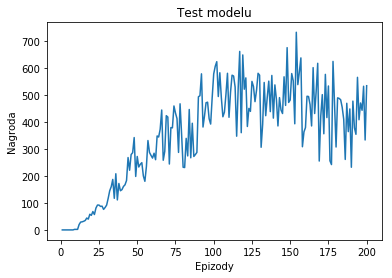

array([-0.48597259,  0.        ])

In [14]:
# initialization environment
env = gym.make('MountainCar-v0')
env.reset()

# train agent with deepQ_learning
dqn = MountainCarTrain(env=env, learning_rate=0.01, gamma=0.99, epsilon_min=0, episodeNum=200)
reward_tab = dqn.start()
env.reset()


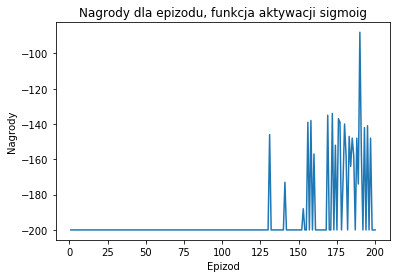

array([-0.49745639,  0.        ])

In [15]:
#
plt.plot(1 * (np.arange(len(reward_tab)) + 1), reward_tab)
plt.xlabel('Epizod')
plt.ylabel('Nagrody')
plt.title('Nagrody dla epizodu, funkcja aktywacji sigmoig' )
plt.show()
plt.close()
env.reset()

-1.0
-2.0
-3.0
-4.0
-5.0
-6.0
-7.0
-8.0
-9.0
-10.0
-11.0
-12.0
-13.0
-14.0
-15.0
-16.0
-17.0
-18.0
-19.0
-20.0
-21.0
-22.0
-23.0
-24.0
-25.0
-26.0
-27.0
-28.0
-29.0
-30.0
-31.0
-32.0
-33.0
-34.0
-35.0
-36.0
-37.0
-38.0
-39.0
-40.0
-41.0
-42.0
-43.0
-44.0
-45.0
-46.0
-47.0
-48.0
-49.0
-50.0
-51.0
-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
-89.0
-90.0
-91.0
-92.0
-93.0
-94.0
-95.0
-96.0
-97.0
-98.0
-99.0
-100.0
-101.0
-102.0
-103.0
-104.0
-105.0
-106.0
-107.0
-108.0
-109.0
-110.0
-111.0
-112.0
-113.0
-114.0
-115.0
-116.0
-117.0
-118.0
-119.0
-120.0
-121.0
-122.0
-123.0
-124.0
-125.0
-126.0
-127.0
-128.0
-129.0
-130.0
-131.0
-132.0
-133.0
-134.0
-135.0
-136.0
-137.0
-138.0
-139.0
-140.0
-141.0
-142.0
-143.0
-144.0
-145.0
-146.0
-147.0
-148.0
-149.0
-150.0
-151.0
-152.0
-153.0
-154.0
-155.0
-156.0
-157.0
-158.0
-1

-1.0
-2.0
-3.0
-4.0
-5.0
-6.0
-7.0
-8.0
-9.0
-10.0
-11.0
-12.0
-13.0
-14.0
-15.0
-16.0
-17.0
-18.0
-19.0
-20.0
-21.0
-22.0
-23.0
-24.0
-25.0
-26.0
-27.0
-28.0
-29.0
-30.0
-31.0
-32.0
-33.0
-34.0
-35.0
-36.0
-37.0
-38.0
-39.0
-40.0
-41.0
-42.0
-43.0
-44.0
-45.0
-46.0
-47.0
-48.0
-49.0
-50.0
-51.0
-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
-89.0
-90.0
-91.0
-92.0
-93.0
-94.0
-95.0
-96.0
-97.0
-98.0
-99.0
-100.0
-101.0
-102.0
-103.0
-104.0
-105.0
-106.0
-107.0
-108.0
-109.0
-110.0
-111.0
-112.0
-113.0
-114.0
-115.0
-116.0
-117.0
-118.0
-119.0
-120.0
-121.0
-122.0
-123.0
-124.0
-125.0
-126.0
-127.0
-128.0
-129.0
-130.0
-131.0
-132.0
-133.0
-134.0
-135.0
-136.0
-137.0
-138.0
-139.0
-140.0
-141.0
-142.0
-143.0
-144.0
-145.0
-146.0
-147.0
-148.0
-149.0
-150.0
-151.0
-152.0
-153.0
-154.0
-155.0
-156.0
-157.0
-158.0
-1

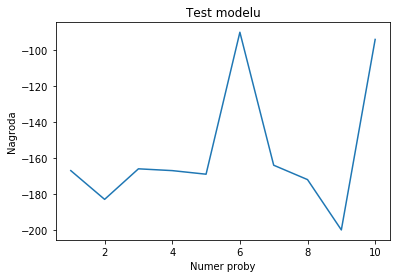

In [16]:
# test model
test(env = env)

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -200.0
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0
E

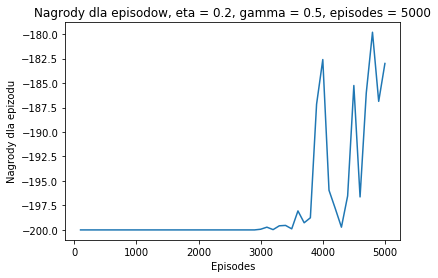

In [20]:
# train agent with Q-learning
rewards = q_learning(env, 0.05, 0.8, 1, 0.02, 5000)

plt.plot(100 * (np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Nagrody dla epizodu')
plt.title('Nagrody dla episodow, eta = 0.05, gamma = 0.8, episodes = 5000')
plt.show()
plt.close()

-1.0
-2.0
-3.0
-4.0
-5.0
-6.0
-7.0
-8.0
-9.0
-10.0
-11.0
-12.0
-13.0
-14.0
-15.0
-16.0
-17.0
-18.0
-19.0
-20.0
-21.0
-22.0
-23.0
-24.0
-25.0
-26.0
-27.0
-28.0
-29.0
-30.0
-31.0
-32.0
-33.0
-34.0
-35.0
-36.0
-37.0
-38.0
-39.0
-40.0
-41.0
-42.0
-43.0
-44.0
-45.0
-46.0
-47.0
-48.0
-49.0
-50.0
-51.0
-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
-89.0
-90.0
-91.0
-92.0
-93.0
-94.0
-95.0
-96.0
-97.0
-98.0
-99.0
-100.0
-101.0
-102.0
-103.0
-104.0
-105.0
-106.0
-107.0
-108.0
-109.0
-110.0
-111.0
-112.0
-113.0
-114.0
-115.0
-116.0
-117.0
-118.0
-119.0
-120.0
-121.0
-122.0
-123.0
-124.0
-125.0
-126.0
-127.0
-128.0
-129.0
-130.0
-131.0
-132.0
-133.0
-134.0
-135.0
-136.0
-137.0
-138.0
-139.0
-140.0
-141.0
-142.0
-143.0
-144.0
-145.0
-146.0
-147.0
-148.0
-149.0
-150.0
-151.0
-152.0
-153.0
-154.0
-155.0
-156.0
-157.0
-158.0
-1

-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
Episode finished


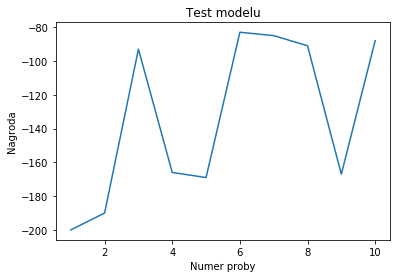

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -200.0
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0
E

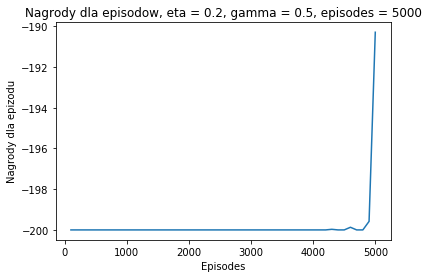

In [21]:
# test model
test(env = env)

# train agent with Q-learning
rewards = q_learning(env, 0.2, 0.2, 0.8, 0, 5000)

plt.plot(100 * (np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Nagrody dla epizodu')
plt.title('Nagrody dla episodow, eta = 0.05, gamma = 0.8, episodes = 5000')
plt.show()
plt.close()